<a href="https://colab.research.google.com/github/alfazick/AppliedLLMCourse/blob/main/part2ExploreMultiModalvLM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Nov 14

In [ ]:
# 1. Clean slate
!pip uninstall transformers trl datasets bitsandbytes peft qwen-vl-utils wandb accelerate -y

# 2. Install stable versions that should work together
!pip install transformers==4.46.2 \
             accelerate==1.0.1 \
             peft==0.13.2 \
             bitsandbytes==0.44.1 \
             datasets==3.0.2 \
             trl==0.11.4 \
             qwen-vl-utils==0.0.8 \
             wandb==0.18.5

# 3. Keep your PyTorch as is (2.4.1+cu121 is fine)

Found existing installation: transformers 5.0.0.dev0
Uninstalling transformers-5.0.0.dev0:
  Successfully uninstalled transformers-5.0.0.dev0
Found existing installation: trl 0.26.0.dev0
Uninstalling trl-0.26.0.dev0:
  Successfully uninstalled trl-0.26.0.dev0
Found existing installation: datasets 4.4.1
Uninstalling datasets-4.4.1:
  Successfully uninstalled datasets-4.4.1
Found existing installation: bitsandbytes 0.48.2
Uninstalling bitsandbytes-0.48.2:
  Successfully uninstalled bitsandbytes-0.48.2
Found existing installation: peft 0.18.0
Uninstalling peft-0.18.0:
  Successfully uninstalled peft-0.18.0
Found existing installation: qwen-vl-utils 0.0.14
Uninstalling qwen-vl-utils-0.0.14:
  Successfully uninstalled qwen-vl-utils-0.0.14
Found existing installation: wandb 0.23.0
Uninstalling wandb-0.23.0:
  Successfully uninstalled wandb-0.23.0
Found existing installation: accelerate 1.11.0
Uninstalling accelerate-1.11.0:
  Successfully uninstalled accelerate-1.11.0
   ━━━━━━━━━━━━━━━━━━━━

In [ ]:
# Cell 2 - MUST restart kernel
import os
os._exit(0)  # This forces kernel restart


In [ ]:
# Always do this at the VERY TOP of notebooks
import os
os.environ['HF_HUB_ENABLE_HF_TRANSFER'] = '0'
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
os.environ['TOKENIZERS_PARALLELISM'] = 'false'


In [ ]:
import importlib
# Cell 3 - Verify exact versions from notebook requirements
requirements = {
    'torch': '2.4.1',
    'transformers': '4.47.0.dev0',
    'trl': '0.12.0.dev0',
    'datasets': '3.0.2',
    'bitsandbytes': '0.44.1',
    'peft': '0.13.2',
    'qwen-vl-utils': '0.0.8',
    'wandb': '0.18.5',
    'accelerate': '1.0.1'
}

print("=== VERSION CHECK ===")
for package, expected in requirements.items():
    try:
        module = importlib.import_module(package.replace('-', '_'))
        actual = getattr(module, '__version__', 'unknown')
        if 'dev' in expected:
            # Dev versions just check if it's dev
            status = "✅" if 'dev' in actual else "⚠️"
        else:
            status = "✅" if actual == expected else "⚠️"
        print(f"{status} {package}: {actual} (expected: {expected})")
    except ImportError:
        print(f"❌ {package}: NOT INSTALLED (expected: {expected})")

=== VERSION CHECK ===
⚠️ torch: 2.4.1+cu121 (expected: 2.4.1)
⚠️ transformers: 4.46.2 (expected: 4.47.0.dev0)
⚠️ trl: 0.11.4 (expected: 0.12.0.dev0)
✅ datasets: 3.0.2 (expected: 3.0.2)
✅ bitsandbytes: 0.44.1 (expected: 0.44.1)
✅ peft: 0.13.2 (expected: 0.13.2)
⚠️ qwen-vl-utils: unknown (expected: 0.0.8)
✅ wandb: 0.18.5 (expected: 0.18.5)
✅ accelerate: 1.0.1 (expected: 1.0.1)


In [ ]:

from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline

In [ ]:
# Task #1)
# get the histogram of the image sizes
# get the histogram of the "bounding boxes" per image
from datasets import load_dataset
dataset_id = "openfoodfacts/nutrition-table-detection"

nutrition_data = load_dataset(dataset_id)


In [ ]:
nutrition_data['train'].features

{'image_id': Value('string'),
 'image': Image(mode=None, decode=True),
 'width': Value('int64'),
 'height': Value('int64'),
 'meta': {'barcode': Value('string'),
  'off_image_id': Value('string'),
  'image_url': Value('string')},
 'objects': {'bbox': List(List(Value('float32'))),
  'category_id': List(Value('int64')),
  'category_name': List(Value('string'))}}

In [ ]:
# so to create a histogram
# I guess I need to calculate width * height

# and then allocate them in specific beans, like may be 10-20
# I don't expect that much diversity between trainning and validation dataset
# but still need to make sure

In [ ]:
nutrition_data

DatasetDict({
    train: Dataset({
        features: ['image_id', 'image', 'width', 'height', 'meta', 'objects'],
        num_rows: 1083
    })
    val: Dataset({
        features: ['image_id', 'image', 'width', 'height', 'meta', 'objects'],
        num_rows: 123
    })
})

In [ ]:
def get_data_sizes(key,dataset):
    arr = list()
    for data_point in dataset[key]:
        width = data_point["width"]
        height = data_point["height"]
        arr.append(width*height)

    return arr


In [ ]:
train_sizes = get_data_sizes("train",nutrition_data)
validate_sizes = get_data_sizes("val",nutrition_data)


In [ ]:
import matplotlib.pyplot as plt


In [ ]:
import numpy as np
def run_stats(arr):
    arr.sort()
    n = len(arr)
    print("Min",min(arr))
    print("Max",max(arr))
    print("Median",arr[n//2])
    print("Avg", sum(arr)/n)


def draw_data(arr,bins,belong):
    arr = [s / 1e6 for s in arr]
    run_stats(arr)
    plt.figure(figsize=(10,6))
    plt.hist(arr,bins=bins)
    plt.xlabel("Image Size(pixels)")
    plt.ylabel("Count")
    plt.title(f"Distribution of Image Sizes,{belong}")
    plt.show()





Min 0.050398
Max 15.872256
Median 5.038848
Avg 5.781028042474607


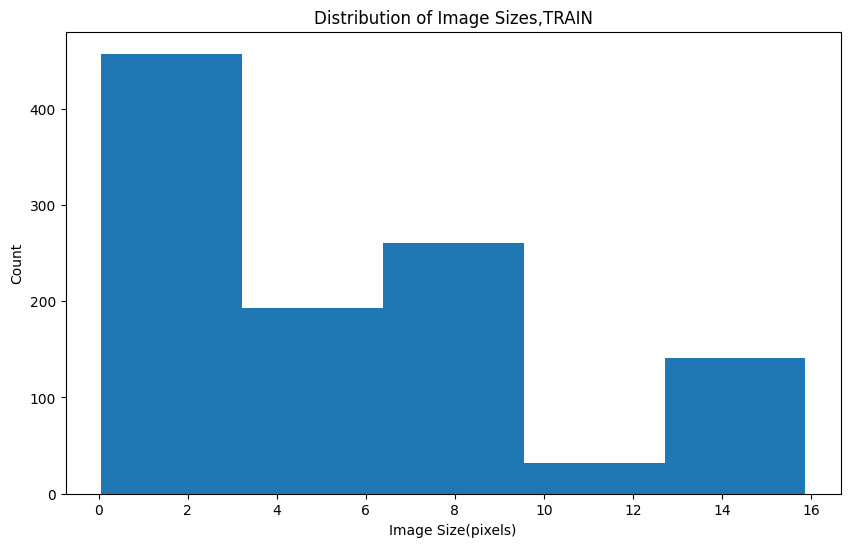

In [ ]:
draw_data(train_sizes,5,"TRAIN")

Min 0.136192
Max 15.872256
Median 5.038848
Avg 5.737920373983739


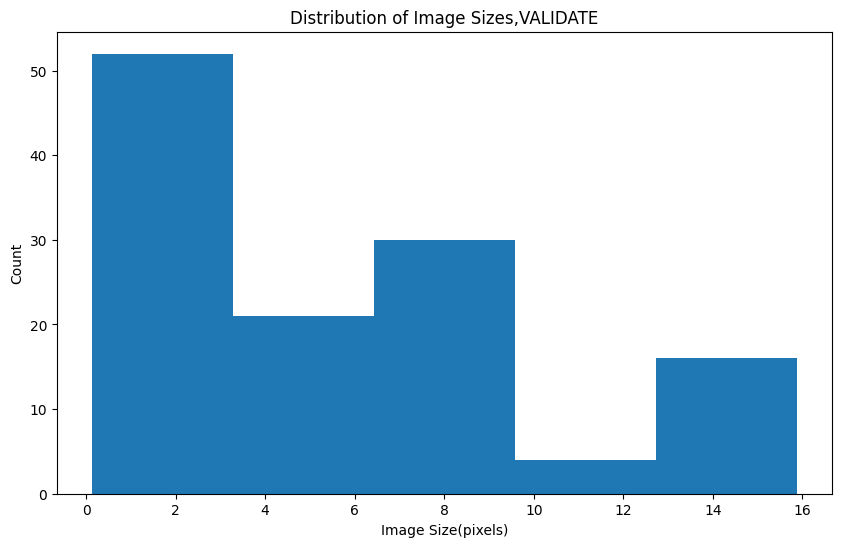

In [ ]:
draw_data(validate_sizes,5,"VALIDATE")

In [ ]:
# ok so like unfortunately not gaussian bell
# so we have two pikes, so effectively bimodal distribution
mln = 1000000
patch = 14*14

# so size of images not promising is high resolution
# so in range 0-3 like 400+ images is 3mln pixels, this should be ok
(3*mln)/patch
# but like upper range outliers 150+ images 14-16mln pixels


15306.122448979591

In [ ]:
(15*mln)/patch

76530.61224489796

In [ ]:
(8*mln)/patch

40816.32653061225

In [ ]:
# this looks not good to me
# but let's not jump to conclusions I don't know how patching works
# ok after learning I need to look the number of tokens per image !


In [ ]:
# get the histogram of the #bounding boxes per image - important for finetuning the model
point = nutrition_data["train"][0]

In [ ]:
point

{'image_id': '0009800892204_1',
 'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=2592x1944>,
 'width': 2592,
 'height': 1944,
 'meta': {'barcode': '0009800892204',
  'off_image_id': '1',
  'image_url': 'https://static.openfoodfacts.org/images/products/000/980/089/2204/1.jpg'},
 'objects': {'bbox': [[0.057098764926195145,
    0.014274691231548786,
    0.603501558303833,
    0.991126537322998]],
  'category_id': [0],
  'category_name': ['nutrition-table']}}

In [ ]:
# ok so before calculating histogram for boxes
# Last time I learned that data format is next
# (y_min, x_min, y_max, x_max)


def extract_single_size(data_point):

    box = data_point["objects"]["bbox"][0]
    height = data_point["height"]
    width = data_point["width"]

    YTopLeft,XTopLeft,YBottomRight,XBottomRight = tuple(box)
    x_start = int(XTopLeft*width)
    y_start = int(YTopLeft*height)
    x_end = int(XBottomRight*width)
    y_end = int(YBottomRight*height)

    size = (x_end - x_start) * (y_end-y_start)

    return size

def get_boxes(key,dataset):
    arr = list()
    for data_point in dataset[key]:
        arr.append(extract_single_size(data_point))
    return arr

boxes_train = get_boxes("train",nutrition_data)


Min 0.001271
Max 11.284352
Median 0.7917
Avg 1.011094539242844


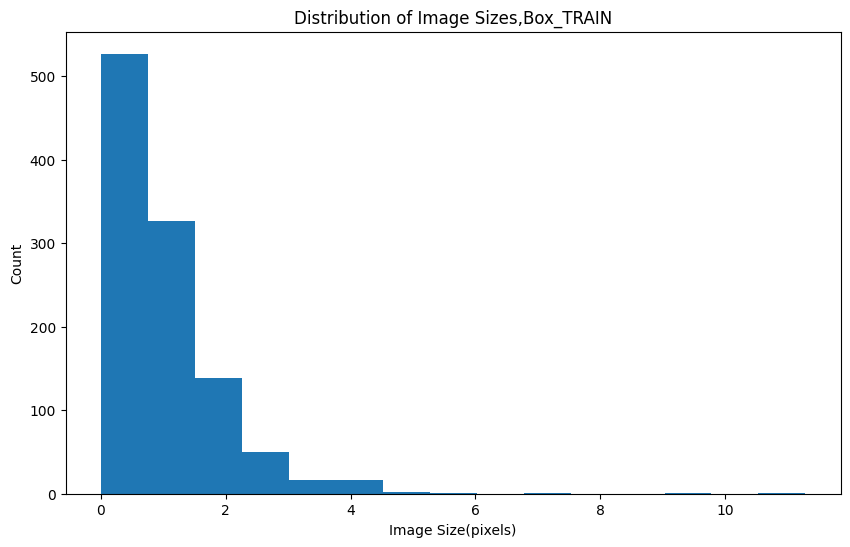

In [ ]:
draw_data(boxes_train,15,"Box_TRAIN")

Min 0.001271
Max 11.284352
Median 0.7917
Avg 1.011094539242844


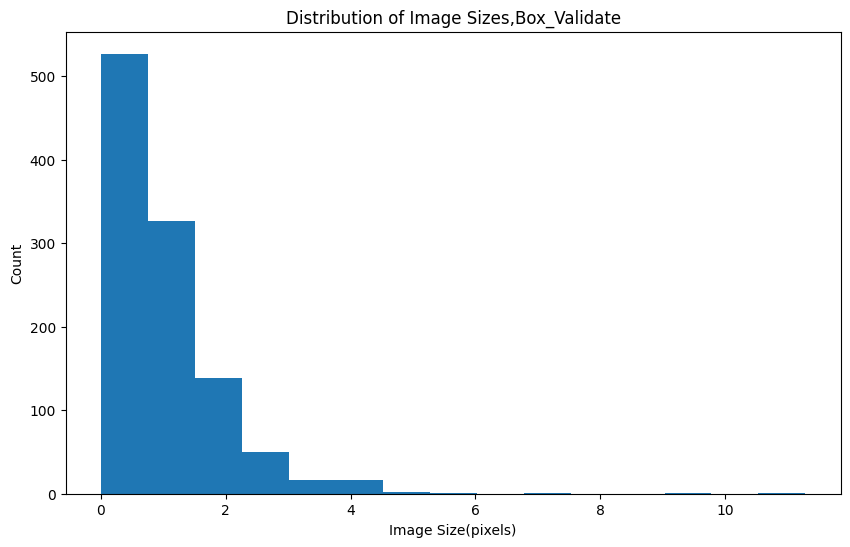

In [ ]:
boxes_val = get_boxes("val",nutrition_data)
draw_data(boxes_train,15,"Box_Validate")

In [ ]:
# ok so here situation is more stable so like most of boxes within 1 mln pixel range
# so like average 1000X1000
# which kind of weird, or to say problematic
# in a some boxes are so tiny relative to image size, not sure if VLM will be able to read it at all

# don't know what to do yet, but probably this data points may affect the final result
# like not sure what to do


In [ ]:
!pip install hf_transfer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 24.7 MB/s  0:00:00 eta 0:00:01


In [ ]:
# ok now big block
# understand process_vision_info
# review the code and determine what this functions returns

import torch
import os
import torch
from transformers import Qwen2VLForConditionalGeneration, Qwen2VLProcessor
from qwen_vl_utils import vision_process
from qwen_vl_utils import process_vision_info


In [ ]:
from PIL import Image, ImageDraw
from matplotlib import pyplot as plt
from transformers import Qwen2VLForConditionalGeneration, AutoProcessor
from qwen_vl_utils import process_vision_info
import torch
import peft
import bitsandbytes as bnb


In [ ]:
# ok let's play with prompts from last week
import torch
import gc

# Clear any existing models
torch.cuda.empty_cache()
gc.collect()
print(f"Allocated: {torch.cuda.memory_allocated()/1024**3:.2f} GB")
print(f"Reserved: {torch.cuda.memory_reserved()/1024**3:.2f} GB")

Allocated: 4.40 GB
Reserved: 4.62 GB


In [ ]:
messages = [
{
    "role":"user",
    "content":[
        {
            "type":"image",
            "image":"https://images.chesscomfiles.com/uploads/v1/images_users/tiny_mce/Ognian_Mikov/php2nnXz9.png",

        },
        {
            "type":"text","text":"Provide surrounding boxes for all pawns in this image and respond in <|bbox|> format"
        },
    ]
}
]

In [ ]:
processor = AutoProcessor.from_pretrained("Qwen/Qwen2-VL-7B-Instruct")


text = processor.apply_chat_template(
    messages, tokenize=False, add_generation_prompt=True
)

In [ ]:
text

'<|im_start|>system\nYou are a helpful assistant.<|im_end|>\n<|im_start|>user\n<|vision_start|><|image_pad|><|vision_end|>Provide surrounding boxes for all pawns in this image and respond in <|bbox|> format<|im_end|>\n<|im_start|>assistant\n'

In [ ]:
#Understand `process_vision_info`
image_inputs,video_inputs = process_vision_info(messages)


In [ ]:
# Understand processor
inputs = processor(text=[text],images=image_inputs,videos=video_inputs,padding=True,return_tensors="pt")

In [ ]:
model = Qwen2VLForConditionalGeneration.from_pretrained(
    "Qwen/Qwen2-VL-7B-Instruct", torch_dtype="auto", device_map="auto"
)

inputs = inputs.to("cuda")
generated_ids = model.generate(**inputs, max_new_tokens=128)
# Step 1: Trimming - Remove the input prompt from output
generated_ids_trimmed = [
    out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
]

output_text = processor.batch_decode(
    generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
)
print(output_text)


Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

Some parameters are on the meta device because they were offloaded to the cpu.


['```json\n[\n  {"bbox": [128, 100, 192, 175]},\n  {"bbox": [128, 250, 192, 325]},\n  {"bbox": [128, 475, 192, 550]},\n  {"bbox": [128, 699, 192, 774]}\n]\n```']


In [ ]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline

from PIL import Image, ImageDraw
from matplotlib import pyplot as plt

img = Image.open("php2nnXz9.png")

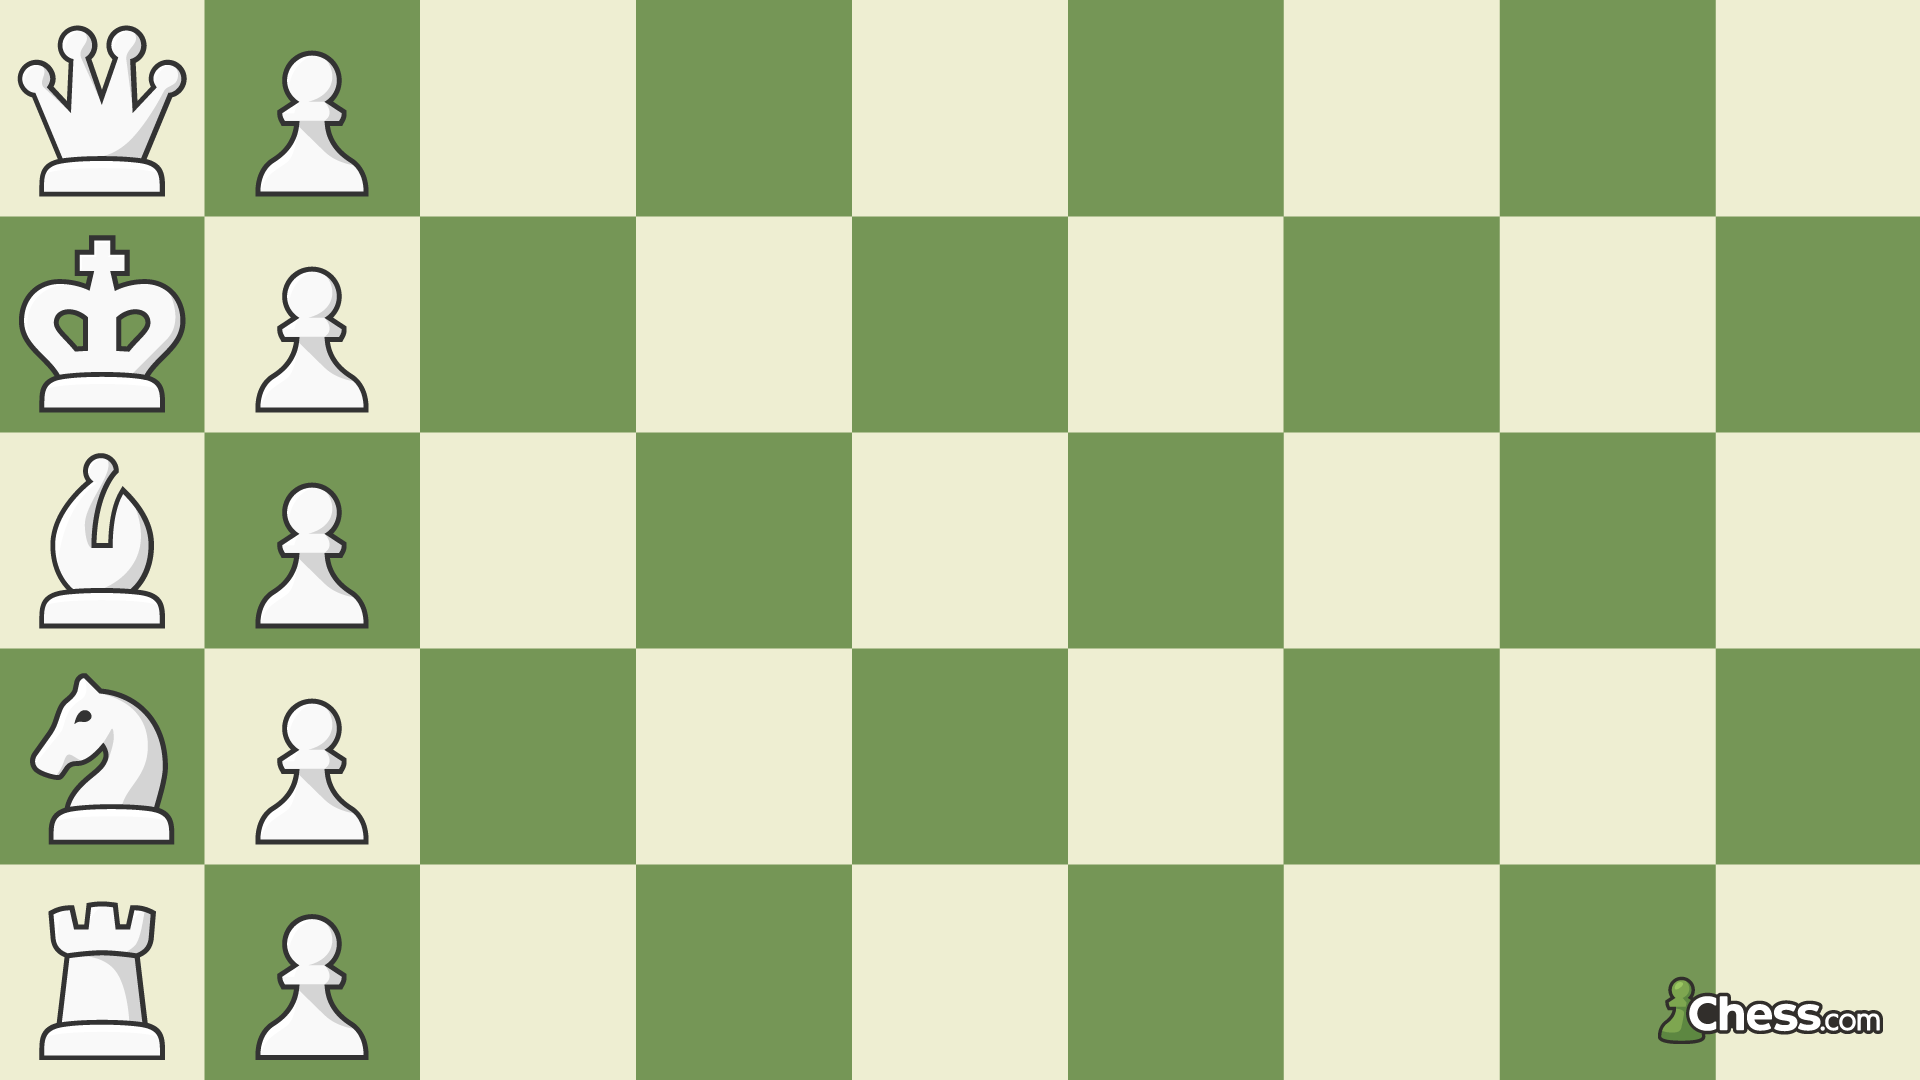

In [ ]:
img

In [ ]:
import json
def extract_boxes(output_str):
    # Handle both with and without ```json markers
    clean = output_str.strip()
    if clean.startswith('```'):
        clean = clean.split('\n', 1)[1].rsplit('\n', 1)[0]

    parsed = json.loads(clean)
    return [item["bbox"] for item in parsed]

boxes_normalized = extract_boxes(output_text[0])

In [ ]:
boxes_normalized

[[128, 100, 192, 175],
 [128, 250, 192, 325],
 [128, 475, 192, 550],
 [128, 699, 192, 774]]

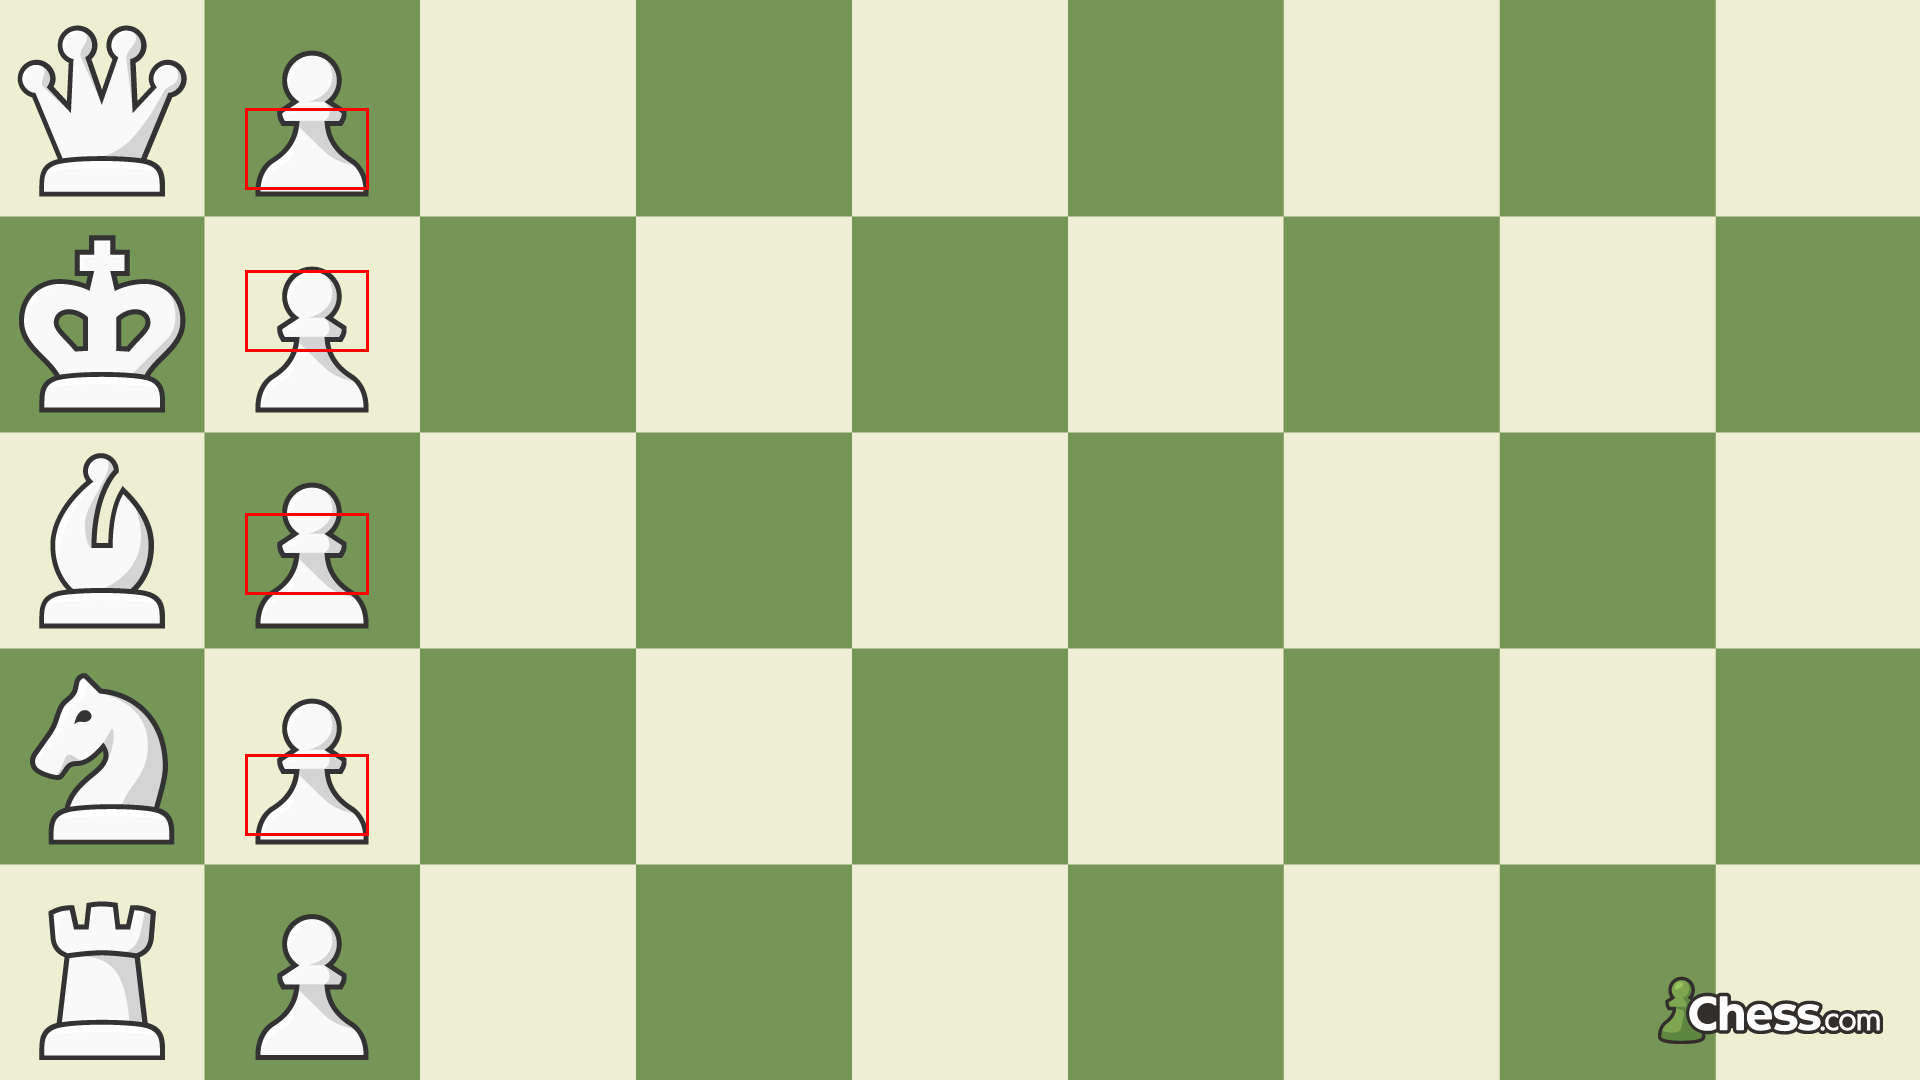

In [ ]:
# ok per last bug. I need to rescale boxes for current image before applying boxes
from PIL import ImageDraw

image = img.copy()  # Make a copy to preserve original

# Get actual image dimensions
img_width, img_height = image.size
draw = ImageDraw.Draw(image)

boxes_01_range = []
for x1, y1, x2, y2 in boxes_normalized:
    x1_norm = x1 / 1000
    y1_norm = y1 / 1000
    x2_norm = x2 / 1000
    y2_norm = y2 / 1000
    boxes_01_range.append([x1_norm, y1_norm, x2_norm, y2_norm])



for x1, y1, x2, y2 in boxes_01_range:
    # Scale from 0-1 to actual image dimensions
    x1_scaled = int(x1 * img_width)
    y1_scaled = int(y1 * img_height)
    x2_scaled = int(x2 * img_width)
    y2_scaled = int(y2 * img_height)

    draw.rectangle([x1_scaled, y1_scaled, x2_scaled, y2_scaled], outline="red", width=3)

image

In [ ]:
# ok changing prompt seems to help, haha it missed one pawn
# but it's much better




In [ ]:
# ok now actual work
# #1) process_vision_info method

In [ ]:
import inspect
from qwen_vl_utils import process_vision_info

# See the source code
print(inspect.getsource(process_vision_info))

def process_vision_info(
    conversations: list[dict] | list[list[dict]],
) -> tuple[list[Image.Image] | None, list[torch.Tensor | list[Image.Image]] | None]:
    vision_infos = extract_vision_info(conversations)
    ## Read images or videos
    image_inputs = []
    video_inputs = []
    for vision_info in vision_infos:
        if "image" in vision_info or "image_url" in vision_info:
            image_inputs.append(fetch_image(vision_info))
        elif "video" in vision_info:
            video_inputs.append(fetch_video(vision_info))
        else:
            raise ValueError("image, image_url or video should in content.")
    if len(image_inputs) == 0:
        image_inputs = None
    if len(video_inputs) == 0:
        video_inputs = None
    return image_inputs, video_inputs



In [ ]:
# ok neat function but I see multiple functions
# which probably expand as a tree
# a) extract_vision_info()
# b) fetch_image()
# c) fetch_video()



In [ ]:
from qwen_vl_utils import extract_vision_info, fetch_image, fetch_video


In [ ]:
print("extract_vision_info:")
print(inspect.getsource(extract_vision_info))


extract_vision_info:
def extract_vision_info(conversations: list[dict] | list[list[dict]]) -> list[dict]:
    vision_infos = []
    if isinstance(conversations[0], dict):
        conversations = [conversations]
    for conversation in conversations:
        for message in conversation:
            if isinstance(message["content"], list):
                for ele in message["content"]:
                    if (
                        "image" in ele
                        or "image_url" in ele
                        or "video" in ele
                        or ele["type"] in ("image", "image_url", "video")
                    ):
                        vision_infos.append(ele)
    return vision_infos



In [ ]:
# ok this a dumb filter function
# just extact all image and video related fields

In [ ]:
print("fetch_image:")
print(inspect.getsource(fetch_image))


fetch_image:
def fetch_image(ele: dict[str, str | Image.Image], size_factor: int = IMAGE_FACTOR) -> Image.Image:
    if "image" in ele:
        image = ele["image"]
    else:
        image = ele["image_url"]
    image_obj = None
    if isinstance(image, Image.Image):
        image_obj = image
    elif image.startswith("http://") or image.startswith("https://"):
        image_obj = Image.open(requests.get(image, stream=True).raw)
    elif image.startswith("file://"):
        image_obj = Image.open(image[7:])
    elif image.startswith("data:image"):
        if "base64," in image:
            _, base64_data = image.split("base64,", 1)
            data = base64.b64decode(base64_data)
            image_obj = Image.open(BytesIO(data))
    else:
        image_obj = Image.open(image)
    if image_obj is None:
        raise ValueError(f"Unrecognized image input, support local path, http url, base64 and PIL.Image, got {image}")
    image = image_obj.convert("RGB")
    ## resize
    if "resized_h

In [ ]:
# ok so at the begining it needs to resolve image_obj
# 1) if it's Image.Image instance just use it
# 2) if url: download with requests lib
# 3) if local file : open :))) i find slicing 7 character funny :))
# 4) if image base64 decode, and then open
# ok after that if no image exist, just error handling

# ok now comes resizing logic
# ok this like is unexpected

# if "resized_height" in ele and "resized_width" in ele:
# what is this like in my messages I am not specifying this paramater

messages = [{
       "role": "user",
       "content": [{
           "type": "image",
           "image": "url.jpg",
           "resized_height": 336,  # Force specific size
           "resized_width": 336
       }]
   }]
# ??? really like I can enforce specific resizing if I don't like
# interesting granular control, not sure how to use

# ok else part looks standard
# so there are hardcoded CONSTANT
# Like MIN_PIXELS and MAX_PIXELS # though it's kind of dummy to expect it from ele


messages = [{
    "role": "user",
    "content": [{
        "type": "image",
        "image": "huge_image.jpg",
        "min_pixels": 50000,    # Override minimum
        "max_pixels": 2000000   # Override maximum
    }]
}]
# except for another method smart_resize()?? what that's suppose to mean




In [ ]:
import qwen_vl_utils
import os

# Read the vision_process.py file
file_path = os.path.join(os.path.dirname(qwen_vl_utils.__file__), "vision_process.py")
with open(file_path, 'r') as f:
    content = f.read()

# Find constant definitions
for line in content.split('\n')[:50]:  # Check first 50 lines where constants usually are
    if '=' in line and any(x in line for x in ['PIXEL', 'FACTOR', 'MIN', 'MAX']):
        print(line)

IMAGE_FACTOR = 28
MIN_PIXELS = 4 * 28 * 28
MAX_PIXELS = 16384 * 28 * 28
MAX_RATIO = 200
VIDEO_MIN_PIXELS = 128 * 28 * 28
VIDEO_MAX_PIXELS = 768 * 28 * 28
VIDEO_TOTAL_PIXELS = 24576 * 28 * 28
FRAME_FACTOR = 2
FPS_MIN_FRAMES = 4
FPS_MAX_FRAMES = 768


In [ ]:
# ok very interesting, so it means our dataset largest images will be rescaled
MAX_PIXELS = 16384 * 28 * 28
mln = 1000*1000

In [ ]:
MAX_PIXELS/mln

12.845056

In [ ]:
from qwen_vl_utils.vision_process import smart_resize
print(inspect.getsource(smart_resize))

def smart_resize(
    height: int, width: int, factor: int = IMAGE_FACTOR, min_pixels: int = MIN_PIXELS, max_pixels: int = MAX_PIXELS
) -> tuple[int, int]:
    """
    Rescales the image so that the following conditions are met:

    1. Both dimensions (height and width) are divisible by 'factor'.

    2. The total number of pixels is within the range ['min_pixels', 'max_pixels'].

    3. The aspect ratio of the image is maintained as closely as possible.
    """
    if max(height, width) / min(height, width) > MAX_RATIO:
        raise ValueError(
            f"absolute aspect ratio must be smaller than {MAX_RATIO}, got {max(height, width) / min(height, width)}"
        )
    h_bar = max(factor, round_by_factor(height, factor))
    w_bar = max(factor, round_by_factor(width, factor))
    if h_bar * w_bar > max_pixels:
        beta = math.sqrt((height * width) / max_pixels)
        h_bar = floor_by_factor(height / beta, factor)
        w_bar = floor_by_factor(width / beta, factor)
    el

In [ ]:
# ok so another strange, this function doesn't resize it calculates dimensions
# but it has 3 functions

import qwen_vl_utils.vision_process as vp

for func in ['round_by_factor', 'floor_by_factor', 'ceil_by_factor']:
    if hasattr(vp, func):
        print(f"\n{func}:")
        print(inspect.getsource(getattr(vp, func)))



round_by_factor:
def round_by_factor(number: int, factor: int) -> int:
    """Returns the closest integer to 'number' that is divisible by 'factor'."""
    return round(number / factor) * factor


floor_by_factor:
def floor_by_factor(number: int, factor: int) -> int:
    """Returns the largest integer less than or equal to 'number' that is divisible by 'factor'."""
    return math.floor(number / factor) * factor


ceil_by_factor:
def ceil_by_factor(number: int, factor: int) -> int:
    """Returns the smallest integer greater than or equal to 'number' that is divisible by 'factor'."""
    return math.ceil(number / factor) * factor



In [ ]:
# ok now the most Interesting Part Tokenization

# Let's see what processor actually does
print(type(processor))
print(dir(processor))

<class 'transformers.models.qwen2_vl.processing_qwen2_vl.Qwen2VLProcessor'>
['__annotations__', '__call__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_auto_class', '_create_repo', '_get_arguments_from_pretrained', '_get_files_timestamps', '_merge_kwargs', '_upload_modified_files', 'apply_chat_template', 'attributes', 'batch_decode', 'chat_template', 'decode', 'feature_extractor_class', 'from_args_and_dict', 'from_pretrained', 'get_processor_dict', 'image_processor', 'image_processor_class', 'model_input_names', 'optional_attributes', 'optional_call_args', 'prepare_and_validate_optional_call_args', 'push_to_hub', 'register_for_auto_class', 'save_pretrained', 'to_dict', 'to_

In [ ]:
# Let's look at the __call__ method
import inspect

# Get the __call__ method source
print(inspect.getsource(processor.__class__.__call__))

    def __call__(
        self,
        images: ImageInput = None,
        text: Union[TextInput, PreTokenizedInput, List[TextInput], List[PreTokenizedInput]] = None,
        videos: VideoInput = None,
        **kwargs: Unpack[Qwen2VLProcessorKwargs],
    ) -> BatchFeature:
        """
        Main method to prepare for the model one or several sequences(s) and image(s). This method forwards the `text`
        and `kwargs` arguments to Qwen2TokenizerFast's [`~Qwen2TokenizerFast.__call__`] if `text` is not `None` to encode
        the text. To prepare the vision inputs, this method forwards the `vision_infos` and `kwrags` arguments to
        Qwen2VLImageProcessor's [`~Qwen2VLImageProcessor.__call__`] if `vision_infos` is not `None`.

        Args:
            images (`PIL.Image.Image`, `np.ndarray`, `torch.Tensor`, `List[PIL.Image.Image]`, `List[np.ndarray]`, `List[torch.Tensor]`):
                The image or batch of images to be prepared. Each image can be a PIL image, NumPy array o